# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

Invalid requirement: './python'
It looks like a path. File './python' does not exist.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='./Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

#Actor and Critic Networks
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)

In [14]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

#Agent
BUFFER_SIZE = int(1e5)    # replay buffer size
BATCH_SIZE = 128          # minibatch size
GAMMA = 0.99              # discount factor
TAU = 1e-3                # for soft update of target parameters
LR_ACTOR = 1e-4           # learning rate of the actor 
LR_CRITIC = 1e-4          # learning rate of the critic
WEIGHT_DECAY_actor = 0.0  # L2 weight decay
WEIGHT_DECAY_critic = 0.0 # L2 weight decay

class Agent():
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR, weight_decay=WEIGHT_DECAY_actor)

        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY_critic)

        self.noise = OUNoise((num_agents, action_size), random_seed) #both singe and multiple agent

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        for index in range(self.num_agents):
            self.memory.add(states[index], actions[index], rewards[index], next_states[index], dones[index])

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            actions += self.noise.sample()

        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        #clip the gradient for the critic as per udacity recommendation
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1.0) 
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [7]:
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=env_info.vector_observations.shape[1], 
              action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  
              random_seed=0)

def ddpg(n_episodes=1000):
    scores_deque = deque(maxlen=100)
    collected_scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations                   
        agent.reset() 
        scores = np.zeros(num_agents)                          
        
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            scores += rewards                                  
            agent.step(states, actions, rewards, next_states, dones) 
            
            # do extra learning
            if len(agent.memory) > BATCH_SIZE:
                for _ in range(3):
                    experiences = agent.memory.sample()
                    agent.learn(experiences, GAMMA)
            
            states = next_states                               
            if np.any(dones):                                  
                break
        
        scores_deque.append(np.mean(scores))
        collected_scores.append(np.mean(scores))
        
        print('Episode {} \tAverage Score: {:.2f} \t Score: {}'.format(i_episode, np.mean(scores_deque), np.mean(scores)))
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {} \tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return collected_scores

In [ ]:
ddpg()


Episode 1	Average Score: 0.73	Score: 0.7334999836049974
Episode 2	Average Score: 0.46	Score: 0.18999999575316906
Episode 3	Average Score: 0.53	Score: 0.6774999848566949
Episode 4	Average Score: 0.73	Score: 1.3264999703504146
Episode 5	Average Score: 0.92	Score: 1.6859999623149633
Episode 6	Average Score: 1.10	Score: 1.962999956123531
Episode 7	Average Score: 1.39	Score: 3.182999928854406
Episode 8	Average Score: 1.61	Score: 3.0929999308660627
Episode 9	Average Score: 1.84	Score: 3.682999917678535
Episode 10	Average Score: 2.27	Score: 6.170499862078577
Episode 11	Average Score: 2.71	Score: 7.10199984125793
Episode 12	Average Score: 3.19	Score: 8.45699981097132
Episode 13	Average Score: 4.27	Score: 17.19149961574003
Episode 14	Average Score: 5.83	Score: 26.19549941448495
Episode 15	Average Score: 7.55	Score: 31.587499293964356
Episode 16	Average Score: 9.26	Score: 34.887999220192434
Episode 17	Average Score: 10.90	Score: 37.105499170627446
Episode 18	Average Score: 12.43	Score: 38.432999

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)

In [7]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=lambda storage, loc: storage))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location=lambda storage, loc: storage))

In [9]:
import matplotlib.pyplot as plt

def ddpg_inference(n_episodes=100):
    result = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]    
        states = env_info.vector_observations                   
        agent.reset() 
        scores = np.zeros(num_agents)    
        
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            scores += rewards                                  
            states = next_states            
            
            if np.any(dones):                                  
                break
                
        print('Episode {}: {}'.format(i_episode, np.mean(scores)))
        result.append(np.mean(scores))
        
    print('Mean score is: ', np.mean(np.array(result)))
    return result

scores = ddpg_inference()


Episode 1: 35.98949919557199
Episode 2: 36.12499919254333
Episode 3: 34.48399922922253
Episode 4: 33.484999251551926
Episode 5: 34.03649923922494
Episode 6: 35.93349919682369
Episode 7: 35.40499920863658
Episode 8: 34.891999220103024
Episode 9: 35.37399920932948
Episode 10: 32.924499264080076
Episode 11: 32.377999276295306
Episode 12: 35.009499217476694
Episode 13: 36.21849919045344
Episode 14: 34.42499923054129
Episode 15: 34.59699922669679
Episode 16: 33.5424992502667
Episode 17: 34.82749922154471
Episode 18: 35.21449921289459
Episode 19: 35.44349920777604
Episode 20: 35.370999209396544
Episode 21: 35.700499202031644
Episode 22: 34.159499236475675
Episode 23: 34.097499237861484
Episode 24: 34.42649923050776
Episode 25: 34.81199922189116
Episode 26: 35.90549919744954
Episode 27: 34.482499229256064
Episode 28: 37.077499171253294
Episode 29: 34.275499233882876
Episode 30: 34.56049922751263
Episode 31: 34.462999229691924
Episode 32: 34.55399922765791
Episode 33: 35.05849921638146
Episode

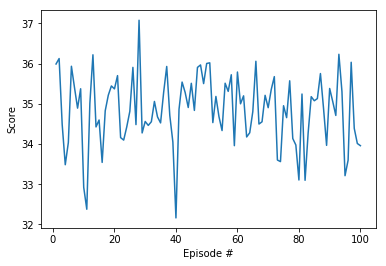

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 